In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from cartopy import crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

from rpy2 import robjects
from rpy2.robjects.packages import importr, data
from rpy2.robjects import numpy2ri, default_converter

# Change to the root directory of the repository for renv to work
os.chdir("..")
robjects.r("source('renv/activate.R')")
np_cv_rules = default_converter + numpy2ri.converter
tess3r = importr("tess3r")
data_at = data(tess3r).fetch("data.at")["data.at"]
genotype = data_at[0]
coordinates = data_at[1]
tess3_obj = tess3r.tess3(
    X=genotype,
    coord=coordinates,
    K=robjects.IntVector(range(1, 9)),
    method="projected.ls",
    ploidy=1,
    openMP_core_num=4,
)
with np_cv_rules.context():
    qmatrix = tess3r.qmatrix(tess3_obj, K=5)
coord = np.array(coordinates)
df = gpd.GeoDataFrame(
    np.asarray(genotype),
    geometry=gpd.points_from_xy(coord[:, 0], coord[:, 1], crs="EPSG:4326"),
)

* Project '~/GitHub/datav' loaded. [renv 0.17.3]


During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
R[write to console]: * The project is currently out-of-sync.
* Use `renv::status()` for more details.



== Computing spectral decomposition of graph laplacian matrix: done
Main loop: done
== Computing spectral decomposition of graph laplacian matrix: done
Main loop: done
== Computing spectral decomposition of graph laplacian matrix: done
Main loop: done
== Computing spectral decomposition of graph laplacian matrix: done
Main loop: done
== Computing spectral decomposition of graph laplacian matrix: done
Main loop: done
== Computing spectral decomposition of graph laplacian matrix: done
Main loop: done
== Computing spectral decomposition of graph laplacian matrix: done
Main loop: done
== Computing spectral decomposition of graph laplacian matrix: done
Main loop: done


<GeoAxes: >

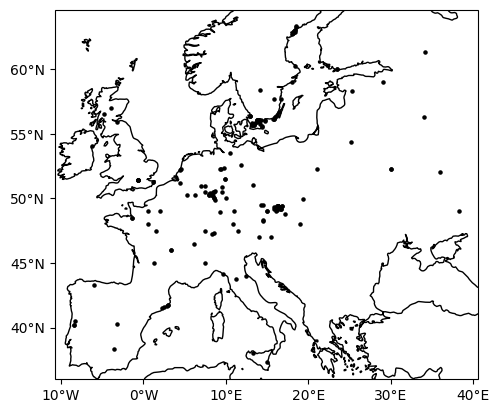

In [2]:
ax = plt.axes(projection=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.coastlines()
ax.set_xticks(range(-10, 41, 10), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 61, 5), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

df.plot(ax=ax, marker="o", color="black", markersize=5)

[Text(0.5, 0, 'Number of ancestral populations'),
 Text(0, 0.5, 'Cross-validation score')]

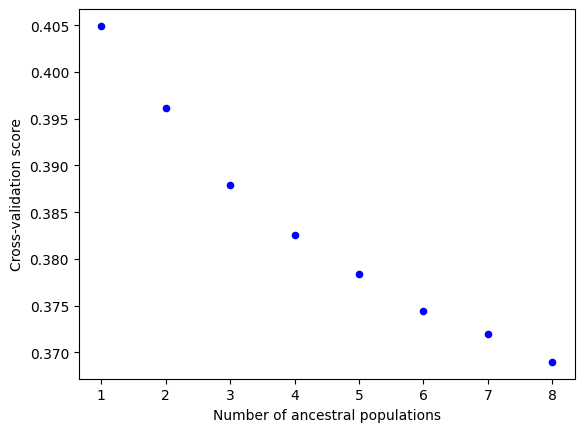

In [3]:
def tess3_to_generator():
    with np_cv_rules.context():
        for _, v in tess3_obj.items():
            tess3_run = v["tess3.run"].byindex(0)[1]
            yield {
                "K": tess3_run["K"][0],
                "crossentropy": v["crossentropy"][0],
                "rmse": v["rmse"][0],
            }


ax = pd.DataFrame(tess3_to_generator()).plot.scatter(x="K", y="rmse", color="blue")
ax.set(xlabel="Number of ancestral populations", ylabel="Cross-validation score")

[Text(0.5, 1.0, 'Ancestry matrix'),
 Text(0, 0.5, 'Ancestry proportions'),
 Text(0.5, 0, 'Individuals'),
 []]

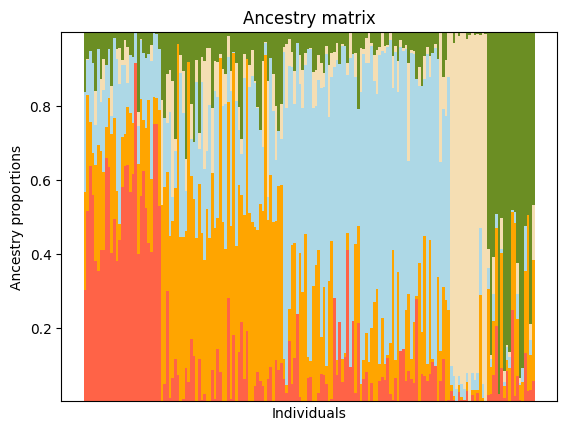

In [4]:
fig, ax = plt.subplots()
bottom = np.zeros(3)

nrows, ncols = qmatrix.shape
bottom = np.zeros(nrows)
K = np.arange(nrows)
colors = ["tomato", "orange", "lightblue", "wheat", "olivedrab"]
Q = qmatrix.copy()
gr = Q.argmax(axis=1)
Qm = Q[gr.argsort()]
for i in range(ncols):
    ax.bar(K, Qm[:, i], 1, label=f"Ancestry {i+1}", bottom=bottom, color=colors[i])
    bottom += Qm[:, i]

ax.set(
    title="Ancestry matrix",
    ylabel="Ancestry proportions",
    xlabel="Individuals",
    xticks=[],
)

/Users/tcztzy/GitHub/datav/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/tcztzy/GitHub/datav/.venv/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[Text(0.5, 1.0, 'Ancestry coefficients')]

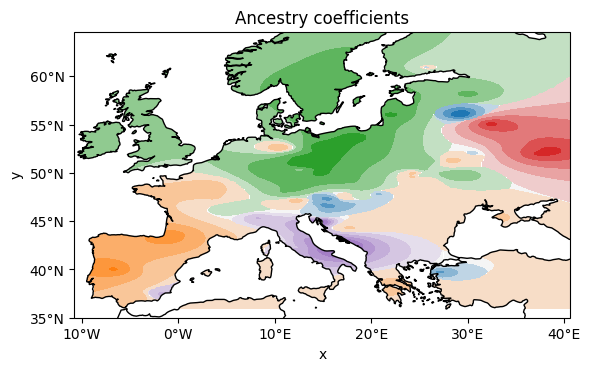

In [5]:
from datav.plot import plot_Q


ax = plt.axes(projection=ccrs.PlateCarree())
Q = gpd.GeoDataFrame(
    qmatrix, geometry=gpd.points_from_xy(coord[:, 0], coord[:, 1], crs="EPSG:4326")
)
plot_Q(Q, ax=ax)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.coastlines()
ax.set_xticks(range(-10, 41, 10), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 61, 5), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set(title="Ancestry coefficients")